In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = 'cpu'
from torchdiffeq import odeint

In [2]:
def FN_torch(t, V, a=0.2, b=0.2, c=3.0):
    return torch.hstack((c * (V[0] - V[0]**3/3 + V[1]), -1/c * (V[0] - a + b*V[1])))

def FN_torch_modified(t, V, eta, a=0.2, b=0.2, c=3.0):
    V1 = c * (V[0] - V[0]**3/3 + V[1])
    V2 = -1/c * (V[0] - a + b*V[1])
    dV = torch.hstack((V1, V2))
    terms = torch.tensor([V[0]**2, V[1]**2])
    dV += torch.matmul(eta, terms)
    return dV

In [20]:
class DiffLoss(torch.nn.Module):
    
    def __init__(self):
        super(DiffLoss, self).__init__()
        
    def forward(self, a, b):
        
        a_diff = torch.diff(a, axis=0)
        b_diff = torch.diff(b, axis=0)
        
        return torch.mean((a_diff - b_diff)**2)

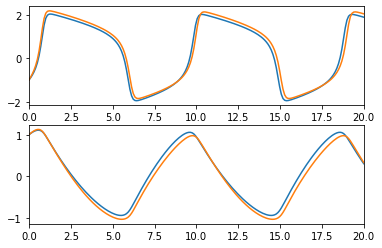

In [3]:
true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)

fn_true = lambda t, x : FN_torch_modified(t, x, true_eta)

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
soln = odeint(fn_true, x0, t_space)

soln_unpert = odeint(FN_torch, x0, t_space)

ax1 = plt.subplot(211)
ax1.set_xlim(0,ub)
plt.plot(t_space, soln_unpert[:,0])
plt.plot(t_space, soln[:,0])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t_space, soln_unpert[:,1])
plt.plot(t_space, soln[:,1])
plt.show()

In [4]:
class OptimizeFitzhugh(torch.nn.Module):
    
    def __init__(self, x0, t_space, n_terms, eta0):
        super(OptimizeFitzhugh, self).__init__()
        self.x0 = x0
        self.t_space = t_space
        self.n_terms = n_terms
        self.eta = eta0
        self.eta.requires_grad_()
        
    def rhs(self, x, t):
        return FN_torch_modified(t, x, self.eta)
    
    def forward(self, t, x):
        return self.rhs(x, t)

In [6]:
N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-5

true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)
true_FN = lambda t, x : FN_torch_modified(t, x, true_eta)
true_soln = odeint(true_FN, x0, t_space)

test_eta = torch.tensor(np.zeros((2,2)), dtype=torch.float)
test_FN = lambda t, x : FN_torch_modified(t, x, test_eta)
test_soln = odeint(test_FN, x0, t_space)

print(true_soln)
print(test_soln)

tensor([[-1.0000e+00,  1.0000e+00],
        [-8.6586e-01,  1.0364e+00],
        [-7.1803e-01,  1.0682e+00],
        [-5.4471e-01,  1.0947e+00],
        [-3.2935e-01,  1.1150e+00],
        [-4.7515e-02,  1.1270e+00],
        [ 3.3309e-01,  1.1281e+00],
        [ 8.3243e-01,  1.1144e+00],
        [ 1.3905e+00,  1.0825e+00],
        [ 1.8381e+00,  1.0331e+00],
        [ 2.0774e+00,  9.7205e-01],
        [ 2.1671e+00,  9.0551e-01],
        [ 2.1881e+00,  8.3712e-01],
        [ 2.1828e+00,  7.6842e-01],
        [ 2.1677e+00,  7.0003e-01],
        [ 2.1490e+00,  6.3218e-01],
        [ 2.1288e+00,  5.6502e-01],
        [ 2.1077e+00,  4.9861e-01],
        [ 2.0862e+00,  4.3303e-01],
        [ 2.0643e+00,  3.6833e-01],
        [ 2.0420e+00,  3.0456e-01],
        [ 2.0193e+00,  2.4178e-01],
        [ 1.9963e+00,  1.8003e-01],
        [ 1.9729e+00,  1.1936e-01],
        [ 1.9491e+00,  5.9803e-02],
        [ 1.9250e+00,  1.4114e-03],
        [ 1.9004e+00, -5.5779e-02],
        [ 1.8755e+00, -1.117

In [17]:
loss = torch.nn.MSELoss()

print(torch.mean((true_soln - test_soln)**2))
print(loss(true_soln, test_soln))

tensor(0.0315, grad_fn=<MeanBackward0>)
tensor(0.0315, grad_fn=<MseLossBackward0>)


In [19]:
true_diff = torch.diff(true_soln, axis=0)
test_diff = torch.diff(test_soln, axis=0)

print(torch.mean((true_diff - test_diff)**2))
print(loss(true_diff, test_diff))

tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)


In [22]:
eta_method = 'random'
check_grads = False
max_it = 100

N = 200
ub = 20

t_space = torch.linspace(0, ub, N)
x0 = torch.tensor([-1.0, 1.0])
x0.requires_grad_()
tol = 10**-5


if eta_method == 'random':
    eta0 = torch.tensor(np.random.normal(0, 0.001, (2,2)), dtype=torch.float).to(device)
elif eta_method == 'zeros':
    eta0 = torch.tensor(np.zeros((2,2)), dtype=torch.float).to(device)
elif eta_method == 'actual':
    eta0 = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float).to(device)
else:
    raise ValueError('You are trying to set eta in a way that is not supported. Check eta_method.')

print(eta0)

with torch.no_grad():
    true_eta = torch.tensor([[0.3, 0], [0, 0.05]], dtype=torch.float)
    true_FN = lambda t, x : FN_torch_modified(t, x, true_eta)
    true_soln = odeint(true_FN, x0, t_space)


optfitz = OptimizeFitzhugh(x0, t_space, 2, eta0).to(device)


optimizer = torch.optim.Adam([optfitz.eta], lr=10**-3)
loss = DiffLoss().to(device)

print('eta_0 = \n{}\n'.format(optfitz.eta.detach().numpy()))

loss_vec = []
eta_log = []

np.set_printoptions(precision=4)
for it in range(max_it):

    optimizer.zero_grad()

    pred_soln = odeint(optfitz, x0, t_space).to(device)

    loss_curr = loss(pred_soln, true_soln)
    loss_curr.retain_grad()
    loss_curr.backward()

    if check_grads:
        if it > 0:
            for i in range(optfitz.eta.shape[0]):
                for j in range(optfitz.eta.shape[1]):
                    print('Backprop Derivative for {},{} = {:.2f}'.format(i, j, optfitz.eta.grad[i,j]))
                    print('Checked Derivative for {},{} = {:.2f}'.format(i, j, grad_check[i,j]))
                    # print('Error Ratio = {:.2f}'.format(optfitz.eta.grad[i,j] / grad_check[i,j]))
                    print()
        print('\n')

    print('Iterarion {}'.format(it+1))
    print('eta = \n{}'.format(optfitz.eta.detach().numpy()))
    eta_log.append(optfitz.eta.detach().numpy())
    print('loss = {:.4f}\n\n'.format(loss_curr))

    if np.linalg.norm(optfitz.eta.grad.detach().numpy()) < tol:
        if not (eta_method == 'actual' and it < 1):
            break

    loss_vec.append(loss_curr.detach().numpy())

    if check_grads:

        print('===Derivative Check===')

        grad_check = np.zeros((optfitz.eta.shape[0], optfitz.eta.shape[1]))
        for i in range(optfitz.eta.shape[0]):
            for j in range(optfitz.eta.shape[1]):
                eps = 10**(-3)
                eta_check_0 = optfitz.eta.detach().clone()
                eta_check_1 = optfitz.eta.detach().clone()

                eta_check_0[i,j] += eps
                eta_check_1[i,j] -= eps

                FN_check_0 = lambda t, S : FN_torch_modified(t, S, eta_check_0)
                x_pred_check_0 = odeint(FN_check_0, x0, t_space)
                FN_check_1 = lambda t, S : FN_torch_modified(t, S, eta_check_1)
                x_pred_check_1 = odeint(FN_check_1, x0, t_space)

                L0 = loss(x_pred_check_0, true_soln)
                L1 = loss(x_pred_check_1, true_soln)
                grad_check[i,j] = ((L0 - L1)/(2*eps)).item()

    optimizer.step()


tensor([[1.5741e-04, 7.7013e-05],
        [5.2232e-04, 1.4168e-03]])
eta_0 = 
[[1.5741e-04 7.7013e-05]
 [5.2232e-04 1.4168e-03]]

Iterarion 1
eta = 
[[1.5741e-04 7.7013e-05]
 [5.2232e-04 1.4168e-03]]
loss = 0.0016


Iterarion 2
eta = 
[[-0.0008  0.0011]
 [ 0.0015  0.0024]]
loss = 0.0012


Iterarion 3
eta = 
[[-0.0018  0.002 ]
 [ 0.0025  0.0034]]
loss = 0.0008


Iterarion 4
eta = 
[[-0.0028  0.0029]
 [ 0.0035  0.0044]]
loss = 0.0006


Iterarion 5
eta = 
[[-0.0036  0.0034]
 [ 0.0044  0.0053]]
loss = 0.0005


Iterarion 6
eta = 
[[-0.0043  0.0035]
 [ 0.0052  0.006 ]]
loss = 0.0005


Iterarion 7
eta = 
[[-0.0046  0.0032]
 [ 0.0058  0.0066]]
loss = 0.0006


Iterarion 8
eta = 
[[-0.0047  0.0027]
 [ 0.0063  0.007 ]]
loss = 0.0006


Iterarion 9
eta = 
[[-0.0045  0.0021]
 [ 0.0065  0.0072]]
loss = 0.0007


Iterarion 10
eta = 
[[-0.0042  0.0013]
 [ 0.0066  0.0072]]
loss = 0.0007


Iterarion 11
eta = 
[[-0.0037  0.0005]
 [ 0.0065  0.007 ]]
loss = 0.0007


Iterarion 12
eta = 
[[-0.0031 -0.0003]
 [ 

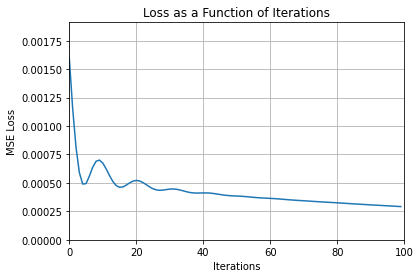

In [23]:
fig, ax = plt.subplots(1,1)
ax.plot(range(len(loss_vec)), loss_vec)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Loss as a Function of Iterations')
ax.set_xlim((0, max_it))
ax.set_ylim((0, max(loss_vec) * 1.2))
plt.grid()
plt.show()